<a href="https://colab.research.google.com/github/troniak/Geocoding-Proxy/blob/master/cavnue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prompt: 
We (Cavnue) are interested in deploying a set of sensors and algorithms to detect lane-level events of interest and deploy a CAV-Enabled Corridor. We want to have initial discussions with people who work in the Department of Transportation in the state, as well as bus service providers. 

For purposes of this exercise, we're interested in talking to the Nebraska DOT about the corridor between Lincoln, Nebraska and Omaha, Nebraska along I-80 and State Route 6 


Goal: 
Create a monitoring system that enables the following capabilities

Identifies lane level performance including

Peak lane demand/congestion

Minimum and maximum velocities of road-users

Volume and class (car/truck/motorcyclist) of road-users per lane

Observes areas of interest for safety-related events

Anomalous lane-to-lane behavior at splits/merges/exits/entrances

Pedestrian crossing at unsignalized intersections/pedestrians on side of road/in-shoulder

Identifies operational hazards

Disabled vehicle in roadway

Debris in roadway

Wrong-way vehicle driving

Task
Describe a series of model lifecycle steps and measurements at each stage to indicate if you are on the right direction or wrong track. This includes defining initial data sets for model bootstrapping in the absence of data collected from the corridor, labeling strategies for data from the corridor, model architecture selection, data selection for both training and validation of models, and how you would conduct analysis of alternatives. If time permits, describe how you would address monitoring for model drift post-deployment, and the frequency with which you would refine and retune your model.

 

Please submit your answers as either a word document, ppt deck, or pdf with diagrams as necessary. 

#Problem Definition 
Human errors remain the largest contributing factor to safety and congestion related incidents, approximately 94% of all motor‐vehicle accidents, leading to over 33,000 national annual fatalities, from 2009 through 2014. In addition, congestion related system inefficiencies wastes an annual $160B in time and fuel, and accounts for nearly 24% of the Greenhouse Gas Emissions throughout the US. [1]  
We (Cavnue) wish to address these issues by detecting lane-level events through deploying CAV-Enabled Corridors. Such lane-level events include, but are not limited to, peak lane demand/congestion, minimum and maximum velocities of road-users, volume and class of road-users per lane, anomalous lane-to-lane behavior, as well as the identification of hazards such as pedestrians, debris or wrong-way driving vehicle in the roadway/shoulder.

#Approach  
Lane-level event detection shall be supported by a series of computer vision and machine learning based technologies developed by us, including object detection, localization and tracking of objects of interest in video feeds monitoring these corridors. At this stage, we work closely with the customer and the current state of the art to ensure a proper solution gets deployed that meets the customer's satisfaction.  
![Optical Flow](https://nanonets.com/blog/content/images/2019/04/of-2.gif "Optical Flow")

#Goals and Milestones
Gantt chart?  
Metrics: does it fit the greater timeline, analysis of each of the pieces in more detail, is it feasible


#Data Gathering    
The power of a machine learning (ML) system comes from the quality of its data. Any customer sponsored data that can be made available could be useful in initial iterations of the ML model. Useful data includes measurements of interest collected, such as through manual labeling, pilot vehicles, etc. secondary measurements, such as meterological data, as well as source data from which those measurements can be reproduced, such as video feeds.  
If customer data is supplied, we must take time to understand what each of the fields represent and what the data types are so that the information can be parsed and used as input to the ML model.

In [12]:
sr6_data = {'Start Time': ('5:30','5:30'), 'avg': ('50','50'), 'PC':('10','10'), 'Foo': ('Bar','Bar'), 'Video Feed': ('corridor.mp4','corridor.mp4')}
i80_data = {'Start Time': ('6:40','','6:42'), 'Average Speed': ('70','999','72'), 'Peak Congestion':('30','NaN','32'), 'Cam Feed': ('640.mpg','corrupt.zzz','642.mpg')}

def show_data(data):
  assert(len(data)>0)
  print(id(data),':')
  for entry in data:
    print(f"{entry:16}",end="|")
  print()
  row = 0
  done = False
  while(not done):
    for column in data:
      if(row >= len(data[column])): done=True; break
      print(f"{str(data[column][row]):16}",end='|')
    print()
    row+=1
  print('\n\n')

all_data = [sr6_data,i80_data]
for data in all_data:
  show_data(data)

140304083182448 :
Start Time      |avg             |PC              |Foo             |Video Feed      |
5:30            |50              |10              |Bar             |corridor.mp4    |
5:30            |50              |10              |Bar             |corridor.mp4    |




140304083182208 :
Start Time      |Average Speed   |Peak Congestion |Cam Feed        |
6:40            |70              |30              |640.mpg         |
                |999             |NaN             |corrupt.zzz     |
6:42            |72              |32              |642.mpg         |







#Data Preparation  
At this stage, we take ownership of the data we have received. We combine, format, 
Metrics: can we query for specific features

In [13]:
from datetime import datetime

# Formatting rules for columns
format_rules = {\
'Average Speed' : (lambda s: float(s)),
'Start Time' : (lambda s: datetime.strptime(s, '%H:%M').time())}
join_rules = {'Foo':['Foo'],'Start Time':['Start Time'],'Average Speed':['Average Speed','avg'],'Video Feed':['Video Feed','Cam Feed'],'Peak Congestion':['PC','Peak Congestion']}
def parse_entry(entry,column):
  '''parse entries using set of predefined rules based on column type'''
  try: 
    return format_rules[column](entry) if column in format_rules else entry
  except ValueError as ve: 
    return 'INVALID'

def parse_column(data,column):
  '''parse a column of data to a list of valid python datatypes if possible'''
  data[column] = [parse_entry(s,column) for s in data[column]]

def format_data(data):
  '''format each column of a table of data'''
  for column in data: parse_column(data,column)
def prepare_data(all_data, label_map):
  prepared_data = dict()
  column_height = 0
  for data in all_data:
    for label in label_map:
      for duplicate in label_map[label]:
        if duplicate in data:
          prepared_data[label] = (prepared_data[label] if label in prepared_data else ()) + data[duplicate]
      column_height = max(column_height,len(prepared_data[label]))
    for label in label_map:
      prepared_data[label] += tuple(['']*(column_height-len(prepared_data[label])))
    
    #Add the subset_id entry to the table, a unique identifier for the dataset it came from
    prepared_data['subset_id'] = (prepared_data['subset_id'] if 'subset_id' in prepared_data else ()) + tuple([f'{id(data)}']*(column_height-(len(prepared_data['subset_id']) if 'subset_id' in prepared_data else 0)))

  return prepared_data
prepared_data = prepare_data(all_data,join_rules)
format_data(prepared_data)
show_data(prepared_data)
print('Average Speeds: ', prepared_data['Average Speed'])

140304083430208 :
Foo             |Start Time      |Average Speed   |Video Feed      |Peak Congestion |subset_id       |
Bar             |05:30:00        |50.0            |corridor.mp4    |10              |140304083182448 |
Bar             |05:30:00        |50.0            |corridor.mp4    |10              |140304083182448 |
                |06:40:00        |70.0            |640.mpg         |30              |140304083182208 |
                |INVALID         |999.0           |corrupt.zzz     |NaN             |140304083182208 |
                |06:42:00        |72.0            |642.mpg         |32              |140304083182208 |




Average Speeds:  [50.0, 50.0, 70.0, 999.0, 72.0]


#Data Cleaning  
scrub for duplicates (remove), validity (remove/correct), missing (interpolate), outliers (remove/mark)  
Metrics: no erroneous entries  

In [15]:

import scipy
import pandas

def clean_data(data):
  for column in data:
    #print(data)
    #parse_column(data,column)
    #print(data)
    #for i in range(len(data[column])):
    #  print(data[column][i])
  return data

cleaned_data = clean_data(prepared_data.copy())
show_data(cleaned_data)

IndentationError: ignored

#Data Analysis  
Frequency distrubution, histogram, bi/multi-feature, insights  
Metrics: can we gather macro statistics, do they make sense


#Feature Engineering  
Which features are important (correlation, IG, random forest), deriving new features, affect the target variable  
Metrics: which features are best at solving the current problem

#Data Verification  
Make sure the data fits the requirements for the model

#Data Sequestering 
80 train, 20 test

#Model Building  
Decision trees, random forest, naive bayes, etc.

#Model Evaluation  
testing, tuning, cross-validation, bias-variance,precision-recall, under/overfitting

#Model Deployment  
scaling, deployment, business consumption, a/b testing, kpi, measure & monitor, feedback loop

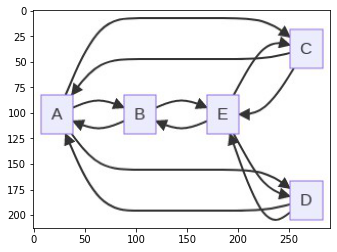

In [ ]:
import base64
import requests, io
from PIL import Image
import matplotlib.pyplot as plt

graph = """
graph LR;
    A--> B & C & D;
    B--> A & E;
    C--> A & E;
    D--> A & E;
    E--> B & C & D;
"""

graphbytes = graph.encode("ascii")
base64_bytes = base64.b64encode(graphbytes)
base64_string = base64_bytes.decode("ascii")
img = Image.open(io.BytesIO(requests.get('https://mermaid.ink/img/' + base64_string).content))
plt.imshow(img)
